### A Markov Decision Process in the Ice Cream Grid World
Consider a gridworld system with noisy dynamics which gets positive rewards $R_D, R_S$ for being in the two blue ice cream store states, and negative reward $R_W$ for being in any red road state. Formulate and solve a complete MDP problem, finding the optimal policy for a variety of task definitions.  Some questions to answer:

How would we formulate a problem that ends with a one-time (discounted) reward $R_D$ or $R_S$ whenever the system is in the respective ice cream store state as an infinite time horizon problem?  What if the reward was not discounted?
How instead would we formulate an infinite horizon, never-ending problem such that the system only achieves a reward upon entering the store rather than simply being in the store?
How many different optimal trajectories can we find by changing just the task definition ($R_D, R_S, R_W, \gamma$), each starting at the same location?
How do those trajectories / policies change as the system dynamics (error probabilities) change?
Under what conditions would it be an optimal strategy to visit both ice cream stores in the same trajectory?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

In [ ]:
# This function computes the transition probability matrix:
def f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=0.9):
  # Inputs:
  # n = board size
  # o_v = array of obstacles
  # i_v = array of ice cream shops
  # r_v = array of roads
  # p = Bernoulli probability
  # Outputs:
  # T = transition probability matrix (N_states x N_actions x N_states)
    # 1st coord = current state, 2nd coord = actions, 3rd coord = next state
  N_states = n**2 # Number of states
  N_actions = 5 # Number of actions

  # Transition probability matrix:
  T = np.zeros((N_states,N_actions,N_states))

  p1 = p # Transition probability of desired actions
  p2 = (1-p1)/(N_actions - 1) # Transition probability of other actions
  pv = np.array([p1, p2, p2, p2, p2]) # Array of probabilities.
  # We will cycle through pv from right to left
  # Actions: stay, down, up, left, right

  # Loop through actions and states
  # (from state j, using action i, to state j')
  for i in np.arange(N_actions):
      for j in np.arange(N_states):
          # If we're not at an obstacle:
          if j not in o_v:
              # Stay in the same state:
              T[j,i,j] = pv[i]

          # If we're not in the right column / no obstacles:
          if np.mod(j+1,n) != 0 and j not in o_v and j not in (o_v - 1):
              # Go right:
              T[j,i,j+1] = pv[np.mod(i+1,N_actions)]
          # If we're not in the left column / no obstacles:
          if np.mod(j,n) != 0 and j not in o_v and j not in (o_v + 1):
              # Go left:
              T[j,i,j-1] = pv[np.mod(i+2,N_actions)]
          # If we're not in the top row / no obstacles:
          if j > n-1 and j != 11 and j not in o_v and j not in (o_v + n):
              # Go up:
              T[j,i,j-n] = pv[np.mod(i+3,N_actions)]
          # If we're not in the bottom row / no obstacles:
          if j < (N_states - n) and j not in o_v and j not in (o_v - n):
              # Go down:
              T[j,i,j+n] = pv[np.mod(i+4,N_actions)]
            
          # Increase probability of staying in the same state:
          # (We're not already at an obstacle)
          # If we can't move right:
          if np.mod(j+1,n) == 0 or (j in (o_v - 1) and j not in o_v):
              T[j,i,j] += pv[np.mod(i+1,N_actions)]
          # If we can't move left:
          if np.mod(j,n) == 0 or (j in (o_v + 1) and j not in o_v):
              T[j,i,j] += pv[np.mod(i+2,N_actions)]
          # If we can't move up:
          if j <= (n - 1) or (j in (o_v + n) and j not in o_v):
              T[j,i,j] += pv[np.mod(i+3,N_actions)]
          # If we can't move down:
          if j >= (N_states - n) or (j in (o_v - n) and j not in o_v):
              T[j,i,j] += pv[np.mod(i+4,N_actions)]
        
  return T

In [ ]:
n = 5 # Board size
p = 0.9 # Transition probability
o_v = np.array([6,7,16,17]) # Array of obstacle states
i_v = np.array([12,22]) # Array of ice cream shop states
r_v = np.array([4,9,14,19,24]) # Array of road states

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix

In [ ]:
# Check that the transition probabilities sum to 1:

col_sum1 = np.sum(T[:,0,:],axis=1)
col_sum2 = np.sum(T[:,1,:],axis=1)
col_sum3 = np.sum(T[:,2,:],axis=1)
col_sum4 = np.sum(T[:,3,:],axis=1)

print(col_sum1)
print(col_sum2)
print(col_sum3)
print(col_sum4)

# They do.

[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]
[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]
[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]
[1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1.]


<function matplotlib.pyplot.show>

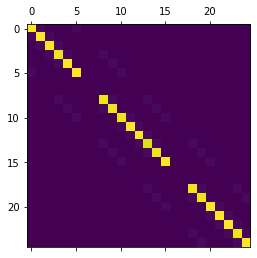

In [ ]:
# # Plot the transition probability matrix:
# for i in np.arange(N_actions):
#     plt.matshow(T[:,i,:])
#     plt.show

# Plot a transition probability matrix:
plt.matshow(T[:,0,:])
plt.show

In [ ]:
# This function computes the reward matrix:
def f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n):

  N_states = n**2 # Number of states
  N_actions = 5
  R1 = np.zeros((N_states,N_actions,N_states)) # Initialize to zero
  for i in np.arange(N_actions):
      for j in np.arange(N_states):
          for c in np.arange(np.shape(i_v)[0]):
            # If we transition to ice cream shop 1:
            R1[j,i,i_v[c]] = Rpts[c] # Award Rd points
          # If we transition to the street:
          for rvi in r_v:
              R1[j,i,rvi] = Rw # Award Rw points
  # Multipy (element-wise) by a mask:
  # (Note: T>0 is the adjacency matrix corresponding to T.
  # This zeroes out the rewards for transitions that are impossible.)
  R = R1*(T>0)
  return R

In [ ]:
Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street

r_v = n*np.arange(n)+(n-1)
Rpts = np.array((Rd,Rs))
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n)

<function matplotlib.pyplot.show>

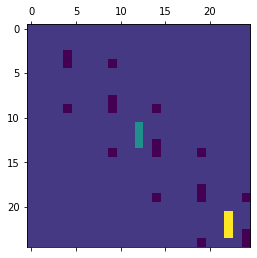

In [ ]:
# Plot the reward matrix:
plt.matshow(R[:,0,:])
plt.show

In [ ]:
# This function performs the value iteration algorithm:
def f_Value_Iteration(n,H,T,R,gamma):
  N_states = n**2 # Number of states
  V = np.zeros(N_states) # Initialize value function

  # Value Iteration:
  for i in np.arange(H):
    a = np.sum(T*(R + gamma*V),axis=2) # Argument of Bellman equation
    A = np.argmax(a,axis=1) # Optimal action
    V = np.max(a,axis=1) # Updated value

  return A, V

In [ ]:
# This function simulates the system with optimal policy:
def f_Simulate(n,H,s0,A,p,rand=0,N_actions=5):

  N_states = n**2 # Number of states
  s_v = np.zeros(H) # Array of states
  s = s0 # Start at initial state

  # Simulate:
  for i in np.arange(H):
    s_v[i] = s # Append the current state to an array.
    if rand == 0:
      # To test the optimal policy, we can pretend the desired
      # states are always the ones to which we transition.
      rt = 0 # Always transition to desired state
    elif rand == 1:
      # Transition to desired state with probability p
      p1 = p
      p2 = (1-p)/(N_actions-1)
      rt = np.random.choice([0,1,2,3,4],p=[p1,p2,p2,p2,p2])
    # We make the desired action with probabilty p1 and make
    # a different transition with probability p2 for each.
    act = A[s] + rt # Adding an element from [0,1,2,3,4]
    # takes us to the same state or the down, up, left, or
    # right states, respectively.

    # If we try to move to the right and we can move to the right:
    if act == 4 and np.mod(s+1,n) != 0 and s not in (o_v - 1):
      s += 1 # Move to the right
    # If we try to move to the left and we can move to the left:
    elif act == 3 and np.mod(s,n) != 0 and s not in (o_v + 1):
      s -= 1 # Move to the left
    # If we try to move up and we can move up:
    elif act == 2 and s > (n-1) and s not in (o_v + n):
      s -= n # Move up
    # If we try to move down and we can move down:
    elif act == 1 and s < (N_states-n) and s not in (o_v - n):
      s += n # Move down
    # Else, stay in the current state.

  return s_v

In [ ]:
# Convert from state to position on board:
def f_State_to_Position(s,n):
  x = int(np.floor(s/n))
  y = int(np.mod(s,n))
  return x,y

In [ ]:
# This function converts the system from
# vector form to matrix form:
def f_Vector_to_Matrix(s_v,i_v,o_v,r_v,n):
# Inputs:
# s_v - an array of states
# i_v - an array of ice cream shops
# o_v - an array of obstacles
# r_v - an array of roads

# Ouputs:
# Ms - a matrix with 1s for states and 0s for nonstates
# M - a matrix with 1 for ice cream shops,
# -1 for obstacles, and -2 for roads.

  # Initialize matrices:
  M = np.zeros((n,n))
  Ms = np.zeros((n,n))

  # Label the states:
  for s in s_v:
    x,y = f_State_to_Position(s,n)
    Ms[x,y] = 1

  # Label the ice cream shops:
  for i in i_v:
    x,y = f_State_to_Position(i,n)
    M[x,y] = 1

  # Label the obstacles:
  for o in o_v:
    x,y = f_State_to_Position(o,n)
    M[x,y] = -1

  # Label the roads:
  for r in r_v:
    x,y = f_State_to_Position(r,n)
    M[x,y] = -2

  return M, Ms

In [ ]:
# This function plots the Ice Cream World:
def f_Plot_board(s_v,i_v,o_v,r_v,n):
    M, Ms = f_Vector_to_Matrix(s_v,i_v,o_v,r_v,n) # Convert to matrix form

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Loop through the boxes in the grid and plot the pieces on the board:
    for i in np.arange(n):
        for j in np.arange(n):
            # Plot the ice cream shops as blue circles:
            if M.T[i,n-1-j] == 1:
                plt.scatter(i+0.5,j+0.5,s=500*(5/n)**2,marker="o",facecolors='none', edgecolors='b')
            # Plot the obstacles as black squares:
            elif M.T[i,n-1-j] == -1:
                plt.scatter(i+0.5,j+0.5,s=1700*(5/n)**2,marker="s",facecolors='k', edgecolors='k')
            # Plot the roads as red squares:
            elif M.T[i,n-1-j] == -2:
                plt.scatter(i+0.5,j+0.5,s=1700*(5/n)**2,marker="s",facecolors='r', edgecolors='r')
            # Plot the states as black dots:
            if Ms.T[i,n-1-j] == 1:
                plt.scatter(i+0.5,j+0.5,s=75*(5/n)**2,marker="o",facecolors='k', edgecolors='k')
    
    plt.xlim(0, n)
    plt.ylim(0, n)
    major_ticks = np.arange(0, n+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.grid(which='both')
    plt.show()

Test Value Iteration:

With a high transition probability, there is little chance of hitting a road, and the MDP chooses the shorter path:

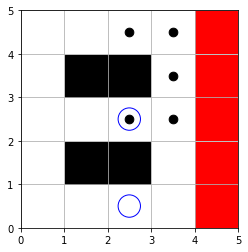

In [ ]:
n = 5 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.3 # Discount factor
H = 10 # Time horizon

o_v = np.array([6,7,16,17]) # Array of obstacle states
i_v = np.array([12,22]) # Array of ice cream shop states
r_v = n*np.arange(n)+(n-1) # Array of road states

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v = f_Simulate(n,H,s0,A,p,rand=0) # Simulate the system
f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot

With a lower transition probability, the MDP takes a longer path in order to avoid the road:

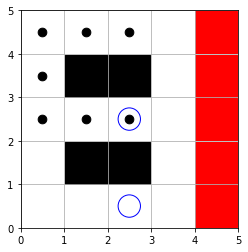

In [ ]:
n = 5 # Board size
p = 0.7 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.3 # Discount factor
H = 10 # Time horizon

o_v = np.array([6,7,16,17]) # Array of obstacle states
i_v = np.array([12,22]) # Array of ice cream shop states
r_v = n*np.arange(n)+(n-1) # Array of road states

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v = f_Simulate(n,H,s0,A,p,rand=0) # Simulate the system
f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot

As we increase the discount factor, the MDP chooses a more distant, but more valuable target:

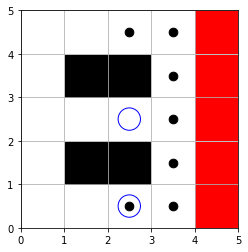

In [ ]:
n = 5 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.7 # Discount factor
H = 10 # Time horizon

o_v = np.array([6,7,16,17]) # Array of obstacle states
i_v = np.array([12,22]) # Array of ice cream shop states
r_v = n*np.arange(n)+(n-1) # Array of road states

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v = f_Simulate(n,H,s0,A,p,rand=0) # Simulate the system
f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot

Let's try a larger board, with randomly placed obstacles, roads, and ice cream shops:

In [ ]:
# Create obstacles, ice cream shops, and roads
def f_Set_Board(n,n_ic=2,s0=2):
  poss_states = np.setdiff1d(np.arange(n**2), s0) # Possible states
  o_v = np.random.choice(poss_states, size=n, replace=False) # Array of obstacle states
  poss_states = np.setdiff1d(poss_states,o_v) # Remaining possible states
  i_v = np.random.choice(poss_states, size=n_ic, replace=False) # Array of ice cream shop states
  poss_states = np.setdiff1d(poss_states,i_v) # Remaining possible states
  r_v = np.random.choice(poss_states, size=n, replace=False) # Array of road states
  return o_v,i_v,r_v

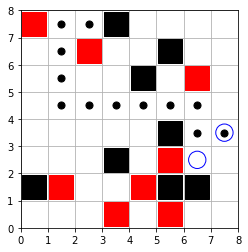

In [ ]:
n = 8 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.7 # Discount factor
H = 20 # Time horizon

o_v,i_v,r_v = f_Set_Board(n,s0=2)

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v = f_Simulate(n,H,s0,A,p,rand=0) # Simulate the system

f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot

## Bayes Filter:

Now, let's say the only feedback we get from the system is the smell of ice cream---that is, we can sense our distance to the ice cream shops.  The measurement value (output/observation) $o$ is related to the harmonic mean $h$ of the (Euclidean) distances to each of the two ice cream shops $d_{D}, d_{S}$: 

$$ 
h = \frac{2}{d_D^{-1} + d_S^{-1}}
$$

$$
o = \begin{cases}
  \lceil h \rceil & \mathrm{w.p.} \quad 1 - (\lceil h \rceil - h ) \\ 
  \lfloor h \rfloor & \mathrm{w.p.} \quad \lceil h \rceil - h 
\end{cases}
$$

Create a Bayes filter on this system and run several examples, displaying the belief state over time as the system executes a series of actions from both known and unknown initial states.

In [ ]:
# Compute harmonic mean of distances to the ice cream shops:
def f_Harmonic_Mean_Distance(s,i_v,n):
  x,y = f_State_to_Position(s,n) # Get x, y position
  denom = 0
  # Loop through array of ice cream shops:
  for i in i_v:
    xi,yi = f_State_to_Position(i,n) # Ice cream position
    dist = np.sqrt((x-xi)**2 + (y-yi)**2) # Distance
    if dist > 0:
      denom += 1/dist # Add 1/dist to denominator
  # If the sum of 1/distances = 0, the harmonic mean = 0
  if denom == 0:
    hm = 0
  # Else, compute harmonic mean
  else:
    hm = np.shape(i_v)[0]/denom
  return hm

In [ ]:
# Compute observation:
def f_Observation(h):
  # Map the harmonic mean h to ceil(h) or floor(h) with probabilities
  # 1 - (ceil(h) - h) and ceil(h) - h, respectively.
  p2 = np.ceil(h) - h
  p1 = 1 - p2
  return np.random.choice((np.ceil(h),np.floor(h)),p=(p1,p2))

In [ ]:
# Returns the probability of an observation o given a state s:
def f_Pr_o_given_s(o,s,i_v,n):
  h = f_Harmonic_Mean_Distance(s,i_v,n) # Mean distance
  # Probabilities of each observation:
  p2 = np.ceil(h)-h
  p1 = 1-p2
  # Pr(ceil(h)|h) = p1
  if o == np.ceil(h):
    pr = p1
  # Pr(floor(h)|h) = p2
  elif o == np.floor(h):
    pr = p2
  # Otherwise, # Pr(o|h(s)) = 0
  else:
    pr = 0
  return pr

In [ ]:
# Given a current state, a set of actions, and a set of transition
# probabilities, transition to a state not blocked by an obstacle.
def f_Transition(s,a,o_v,p,n,N_actions=5,rand=1):
# Inputs:
# s = current state
# a = action
# o_v = array of obstacles
# p = Bernoulli transition probability
# n = board size
# Output:
# s = new state

  N_states = n**2 # Number of states
  if rand == 0:
    # To test the optimal policy, we can pretend the desired
    # states are always the ones to which we transition.
    rt = 0 # Always transition to desired state
  elif rand == 1:
    # Transition probabilities:
    p1 = p
    p2 = (1-p)/(N_actions-1)
    rt = np.random.choice([0,1,2,3,4],p=[p1,p2,p2,p2,p2])
    # We make the desired action with probabilty p1 and make
    # a different transition with probability p2 for each.
  act = a + rt # Adding an element from [0,1,2,3,4]
  # takes us to the same state or the down, up, left, or
  # right states, respectively.

  # If we try to move to the right and we can move to the right:
  if act == 4 and np.mod(s+1,n) != 0 and s not in (o_v - 1):
    s += 1 # Move to the right
  # If we try to move to the left and we can move to the left:
  elif act == 3 and np.mod(s,n) != 0 and s not in (o_v + 1):
    s -= 1 # Move to the left
  # If we try to move up and we can move up:
  elif act == 2 and s > (n-1) and s not in (o_v + n):
    s -= n # Move up
  # If we try to move down and we can move down:
  elif act == 1 and s < (N_states-n) and s not in (o_v - n):
    s += n # Move down
  # Else, stay in the current state.

  return s

In [ ]:
# Update the a priori belief state:
def f_Belief_minus(a,S,T,n,Belief_plus):
  Belief_minus = np.zeros(n**2)
  # T[:,a,:] = transition probability matrix given an action a
  # Matrix product gives the new belief state
  Belief_minus += np.matmul(T[:,a,:],Belief_plus)
  # Note: Belief_minus should already be normalized
  return Belief_minus/sum(Belief_minus)

In [ ]:
# Update the a posteriori belief state:
def f_Belief_plus(o,s,i_v,S,n,Belief_minus):
  pr = np.zeros(n**2)
  for s in S:
    pr[s] = f_Pr_o_given_s(o,s,i_v,n)
  numerator = pr*Belief_minus
  return numerator/sum(numerator)

In [ ]:
# This function simulates the system with Bayes filter and
# the policy found by value iteration.
def f_Simulate_Bayes_Filter(n,H,s0,A,T,p,Belief_0,N_actions=5,rand=0):

  N_states = n**2 # Number of states
  s_v = np.zeros(H) # Initialize array of states
  s_est_v = np.zeros(H) # Initialize array of estimated states
  s = s0 # Start at initial state
  Belief_plus = Belief_0 # Initialize belief state
  S = np.arange(n**2)

  # Simulate:
  for i in np.arange(H):
    s_v[i] = s # Append the current state to an array.
    s_est = np.argmax(Belief_plus) # Estimated state
    s_est_v[i] = s_est # Append the estimated state to array
    a = A[s_est] # Take action using estimated state
    s = f_Transition(s,a,o_v,p,n,rand=rand) # Transition to new state
    Belief_minus = f_Belief_minus(a,S,T,n,Belief_plus) # Belief minus
    h = f_Harmonic_Mean_Distance(s,i_v,n) # Harmonic mean distance
    o = f_Observation(h) # Observation
    Belief_plus = f_Belief_plus(o,s,i_v,S,n,Belief_minus) # Belief plus

  return s_v, s_est_v

In [ ]:
# Plot state and estimated states vs time step
def f_Plot_states(s_v,s_est_v):
  plt.plot(s_v,label="Actual state")
  plt.plot(s_est_v,linestyle="--",label="Estimated state")
  plt.xlabel('Time step')
  plt.ylabel('State')
  plt.grid()
  plt.legend()
  plt.show()

Test the Bayes Filter:

Single goal state and known initial state:

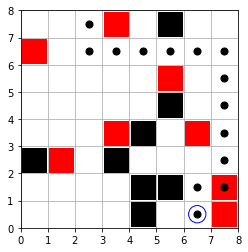

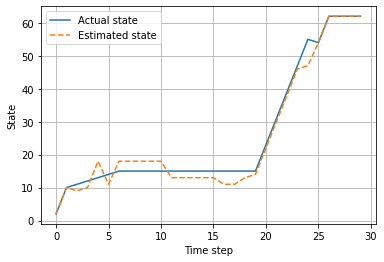

In [ ]:
n = 8 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.7 # Discount factor
H = 30 # Time horizon

# Create arrays of obstacles, ice cream shops, and roads:
o_v,i_v,r_v = f_Set_Board(n,n_ic=1,s0=2)

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rs,Rs)) # Array of ice cream points

# Initialize the belief state:
Belief_0 = np.zeros(n**2) #
Belief_0[s0] += 1 # We know we're starting from s0

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v, s_est_v = f_Simulate_Bayes_Filter(n,H,s0,A,T,p,Belief_0) # Simulate the system

f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot board
f_Plot_states(s_v,s_est_v) # Plot states vs time step

Single goal state and a decent guess of the initial state:

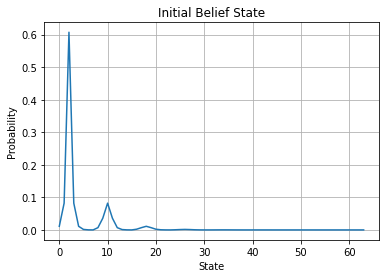

In [ ]:
# Initialize the belief state:
Belief_0 = np.zeros(n**2)
for s in np.arange(n**2):
  Belief_0[s] = np.exp(-2*f_Harmonic_Mean_Distance(s,np.array([s0]),n))
Belief_0 = Belief_0/np.sum(Belief_0) # Normalize to 1

plt.plot(Belief_0)
plt.title('Initial Belief State')
plt.xlabel('State')
plt.ylabel('Probability')
plt.grid()
plt.show()

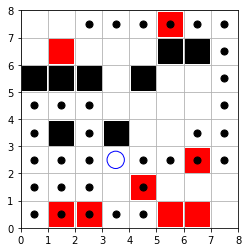

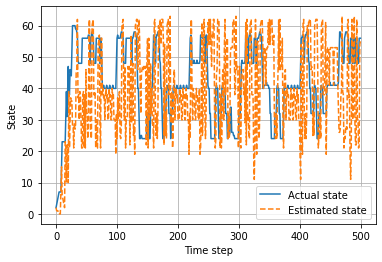

In [ ]:
n = 8 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 1 # Discount factor
H = 500 # Time horizon

# Create arrays of obstacles, ice cream shops, and roads:
o_v,i_v,r_v = f_Set_Board(n,n_ic=1,s0=2)

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rs,Rs)) # Array of ice cream points

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v, s_est_v = f_Simulate_Bayes_Filter(n,H,s0,A,T,p,Belief_0) # Simulate the system

f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot board
f_Plot_states(s_v,s_est_v) # Plot states vs time step

Two goal states and known initial state:

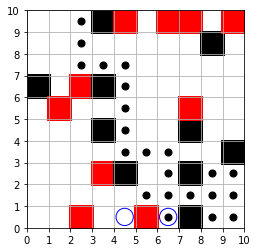

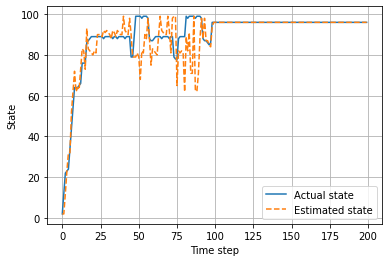

In [ ]:
n = 10 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.95 # Discount factor
H = 200 # Time horizon

# Create arrays of obstacles, ice cream shops, and roads:
o_v,i_v,r_v = f_Set_Board(n,s0=2)

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

# Initialize the belief state:
Belief_0 = np.zeros(n**2) #
Belief_0[s0] += 1 # We know we're starting from s0

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v, s_est_v = f_Simulate_Bayes_Filter(n,H,s0,A,T,p,Belief_0) # Simulate the system

f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot board
f_Plot_states(s_v,s_est_v) # Plot states vs time step

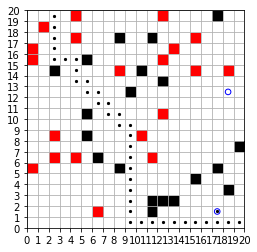

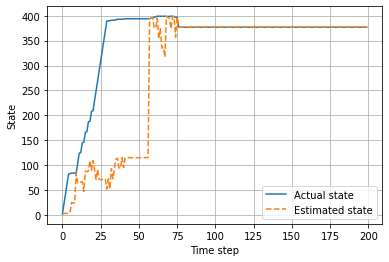

In [ ]:
n = 20 # Board size
p = 0.9 # Transition probability

s0 = 2 # Start at state 2
gamma = 0.95 # Discount factor
H = 200 # Time horizon

# Create arrays of obstacles, ice cream shops, and roads:
o_v,i_v,r_v = f_Set_Board(n,s0=2)

Rd = 2 # Reward for ice cream shop 1
Rs = 5 # Reward for ice cream shop 2
Rw = -1 # Reward for street
Rpts = np.array((Rd,Rs)) # Array of ice cream points

# Initialize the belief state:
Belief_0 = np.zeros(n**2) #
Belief_0[s0] += 1 # We know we're starting from s0

T = f_Transition_Probability_Matrix(n,o_v,i_v,r_v,p=p) # Compute transition matrix
R = f_Reward_Matrix(Rd,Rs,Rw,i_v,r_v,Rpts,n) # Compute reward matrix
A, V = f_Value_Iteration(n,H,T,R,gamma) # Run value iteration
s_v, s_est_v = f_Simulate_Bayes_Filter(n,H,s0,A,T,p,Belief_0) # Simulate the system

f_Plot_board(s_v,i_v,o_v,r_v,n) # Plot board
f_Plot_states(s_v,s_est_v) # Plot states vs time step